DAILY CHALLENGE

Cet exercice est un cas classique de classification de texte, plus spécifiquement de l'inférence de langage naturel (NLI - Natural Language Inference). L'objectif est de déterminer si une phrase "hypothèse" est une conséquence logique (entailment), une contradiction, ou neutre par rapport à une phrase "prémisse".
Le code suit un pipeline standard de projet NLP avec le modèle BERT et le framework PyTorch.
Étape 0 : Préparation de l'Environnement
C'est la toute première étape, qui consiste à s'assurer que toutes les bibliothèques nécessaires sont installées.
!pip -q install ... : Installe les bibliothèques principales :
transformers : Fournit l'accès à des modèles pré-entraînés comme BERT et à leurs tokenizers. C'est la bibliothèque clé de l'exercice.
datasets et evaluate : Outils de l'écosystème Hugging Face pour gérer les données et évaluer les modèles.
scikit-learn : Une bibliothèque classique de machine learning.
accelerate : Aide à optimiser l'entraînement sur différents types de matériel (CPU, GPU, TPU).
!pip install tensorflow : Bien que le code final utilise PyTorch, TensorFlow est installé. Dans ce notebook, il est utilisé au début pour préparer les données (tf.ragged.constant) avant que le reste du script ne soit adapté pour PyTorch.
Étape 1 : Chargement et Préparation des Données
Cette étape consiste à extraire les fichiers de données et à les charger en mémoire.
Décompression des archives : Le code décompresse une première archive ZIP (OUTER_ZIP), puis trouve les archives train.zip et test.zip à l'intérieur et les décompresse à leur tour. Cela permet d'accéder aux fichiers train.csv et test.csv.
Chargement avec Pandas : Les fichiers CSV sont chargés dans des DataFrames Pandas (train_df et test_df). Le DataFrame est une structure de données tabulaire très pratique pour manipuler les données.
Étape 2 : Exploration des Données (EDA - Exploratory Data Analysis)
Avant de construire un modèle, il est crucial de comprendre les données.
Aperçu des données : train_df.head() affiche les 5 premières lignes pour voir la structure (colonnes premise, hypothesis, label, etc.).
Distribution des classes : train_df['label'].value_counts() montre combien d'exemples il y a pour chaque catégorie (0: entailment, 1: neutral, 2: contradiction). C'est important pour vérifier si le jeu de données est équilibré.
Exemple concret : Le code sélectionne une paire prémisse/hypothèse au hasard et l'affiche avec son label textuel pour mieux comprendre la tâche.
Étape 3 : Prétraitement et Encodage des Données
Les modèles de deep learning comme BERT ne comprennent pas le texte brut. Il faut le transformer en nombres. C'est le rôle du tokenizer.
Charger le Tokenizer : BertTokenizer.from_pretrained('bert-base-multilingual-cased') charge un tokenizer pré-entraîné qui sait comment découper le texte en "tokens" (mots ou sous-mots) pour de nombreuses langues.
Créer la fonction d'encodage (bert_encode) : C'est une étape critique.
Elle prend les prémisses et les hypothèses.
Elle les combine en une seule chaîne de caractères, séparées par un token spécial [SEP]. C'est le format que BERT attend pour les tâches de classification de paires de phrases.
Elle utilise le tokenizer pour convertir ce texte en trois tenseurs principaux :
input_ids : L'identifiant numérique de chaque token.
attention_mask : Un masque binaire (0 ou 1) qui indique au modèle quels tokens sont réels et lesquels sont du "padding" (remplissage pour que toutes les séquences aient la même longueur).
token_type_ids : Indique à BERT quelle partie de l'entrée est la première phrase (la prémisse) et quelle partie est la seconde (l'hypothèse).
Étape 4 : Construction du Modèle
Ici, on définit l'architecture du modèle de classification.
Charger le modèle BERT pré-entraîné : BertModel.from_pretrained('bert-base-multilingual-cased') télécharge le corps principal du modèle BERT, déjà entraîné sur des milliards de phrases. On ne part pas de zéro, on fait du transfer learning.
Définir un classifieur personnalisé (BERTClassifier) : On crée une nouvelle classe en PyTorch (nn.Module).
Elle contient le modèle BERT comme une couche.
Elle ajoute une couche de Dropout pour éviter le surapprentissage (overfitting).
Elle ajoute une couche finale nn.Linear (couche "fully connected") qui prend la sortie de BERT et la projette sur 3 sorties (une pour chaque classe : entailment, neutral, contradiction).
Étape 5 : Préparation de l'Entraînement (PyTorch)
Cette partie configure tout ce qui est nécessaire pour lancer l'entraînement.
Conversion en Tenseurs PyTorch : Les données encodées (qui étaient des tenseurs TensorFlow ou des listes NumPy) sont converties en torch.tensor.
Création des Dataset et DataLoader :
TensorDataset regroupe les tenseurs d'entrée et les labels.
DataLoader est un utilitaire très puissant qui gère la création de mini-lots (batches) de données, le mélange des données à chaque époque (shuffle=True), etc. C'est essentiel pour un entraînement efficace.
Définition de l'Optimiseur et de la Fonction de Perte :
optimizer = torch.optim.Adam(...) : L'optimiseur (ici Adam) est l'algorithme qui met à jour les poids du modèle pour minimiser l'erreur.
criterion = nn.CrossEntropyLoss() : La fonction de perte (loss function) mesure l'écart entre les prédictions du modèle et les vrais labels. Pour la classification multi-classes, CrossEntropyLoss est le choix standard.
Configuration du matériel : Le code choisit d'utiliser le GPU (cuda) s'il est disponible, sinon le CPU.
Étape 6 : Entraînement du Modèle (La Boucle d'Entraînement)
C'est le cœur du processus d'apprentissage.
Boucle sur les époques (for epoch in range(epochs):) : Une époque est un passage complet sur l'ensemble des données d'entraînement.
Mode Entraînement (model.train()) : Active certaines couches comme le Dropout.
Boucle sur les batches (for batch in train_dataloader:) :
Récupère un lot de données.
Fait une passe avant (forward pass) : outputs = model(...) pour obtenir les prédictions.
Calcule la perte (loss) : loss = criterion(outputs, labels).
Fait une passe arrière (backward pass / backpropagation) : loss.backward() calcule comment chaque poids du modèle a contribué à l'erreur.
Met à jour les poids : optimizer.step().
Phase de Validation (model.eval()) : Après chaque époque, on évalue le modèle sur le jeu de données de validation.
model.eval() désactive le Dropout pour des prédictions stables.
with torch.no_grad(): désactive le calcul des gradients pour aller plus vite et économiser de la mémoire.
On calcule la perte et la précision sur les données de validation pour surveiller la performance du modèle sur des données qu'il n'a jamais vues pendant l'entraînement.
Étape 7 : Évaluation et Visualisation des Performances
Une fois l'entraînement terminé, on analyse les résultats.
matplotlib.pyplot : Le code trace des graphiques montrant l'évolution de la perte et de la précision (accuracy) pour les données d'entraînement et de validation au fil des époques.
Analyse des graphiques : Cela permet de voir si le modèle a bien appris et de détecter d'éventuels problèmes (ex: si la perte de validation remonte alors que celle d'entraînement continue de baisser, c'est un signe de surapprentissage).
Étape 8 : Inférence et Génération des Prédictions
L'objectif final est d'utiliser le modèle entraîné pour faire des prédictions sur de nouvelles données (le jeu de test).
Prétraitement des données de test : On applique exactement la même fonction bert_encode sur les données de test.
Création d'un DataLoader de test.
Mode Évaluation (model.eval()) : Très important pour s'assurer que les prédictions sont déterministes.
Boucle de prédiction : Le modèle parcourt les données de test et génère des prédictions. torch.max(outputs.data, 1) trouve la classe avec le score le plus élevé pour chaque exemple.
Création du fichier de soumission : Les prédictions sont ajoutées à un nouveau DataFrame et sauvegardées, généralement dans un fichier submission.csv, prêt à être soumis à une compétition (comme sur Kaggle).

Étape 0 : Préparation de l'environnement

In [6]:
!pip install -q transformers datasets evaluate scikit-learn accelerate tensorflow


In [7]:
!rm -r ~/.cache/huggingface/datasets


rm: cannot remove '/root/.cache/huggingface/datasets': No such file or directory


In [8]:
!pip install -U datasets huggingface_hub

Étape 1 : Chargement des données

In [9]:
import pandas as pd

# Chargement direct des fichiers déjà décompressés
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Vérifications rapides
print("Train DataFrame :")
print(train_df.head())
print(train_df.info())

print("\nTest DataFrame :")
print(test_df.head())
print(test_df.info())


Train DataFrame :
           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (tot

Étape 2 : Analyse exploratoire rapide

In [10]:
print(train_df['label'].value_counts())
train_df.sample(1).apply(lambda x: print(f"Premise : {x.premise}\nHypothesis : {x.hypothesis}\nLabel : {x.label}"), axis=1)


label
0    4176
2    4064
1    3880
Name: count, dtype: int64
Premise : From ethnic food shops and vintage clothing stores to electronics and book shops, there are so many interesting shopping spots that it is hard to imagine their breadth and depth.
Hypothesis : There are so many places to shop that you can find anything you need.
Label : 0


,0
11833,None


Étape 3 : Tokenization

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def bert_encode(premises, hypotheses, tokenizer, max_len=128):
    encoded = tokenizer(premises, hypotheses,
                        padding='max_length', truncation=True, max_length=max_len,
                        return_tensors='pt')
    return encoded

sample_encoded = bert_encode(train_df.premise[:2].tolist(), train_df.hypothesis[:2].tolist(), tokenizer)
print(sample_encoded)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 10111, 11762, 61565, 10309, 14289, 10106, 29659, 12141, 10105,
         63313, 23123,   119,   102, 10117, 23123, 14628, 10106, 10105, 63313,
         10309, 14499, 14229, 10169, 11762, 61565, 10106, 21133,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

Étape 4 : Construction du modèle

In [12]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids, attention_mask, token_type_ids)
        pooled_output = output.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

model = BERTClassifier()
print(model)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [13]:
def bert_encode(premises, hypotheses, tokenizer, max_len=128):
    encoded = tokenizer(
        premises,
        hypotheses,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt',
        return_overflowing_tokens=False # suppression du warning
    )
    return encoded


Étape 5 : Préparer l'entraînement

In [14]:
from torch.utils.data import TensorDataset, DataLoader

inputs = bert_encode(train_df.premise.tolist(), train_df.hypothesis.tolist(), tokenizer)
labels = torch.tensor(train_df.label.values)

dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Étape 6 : Entraînement

In [15]:
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in dataloader:
        input_ids, attention_mask, token_type_ids, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = total_correct / len(dataset)
    print(f"Epoch {epoch+1} | Loss : {total_loss:.4f} | Accuracy : {accuracy:.4f}")


Epoch 1 | Loss : 685.9352 | Accuracy : 0.5750
Epoch 2 | Loss : 514.5804 | Accuracy : 0.7144
Epoch 3 | Loss : 345.2759 | Accuracy : 0.8213


Étape 7 : Visualisation rapide

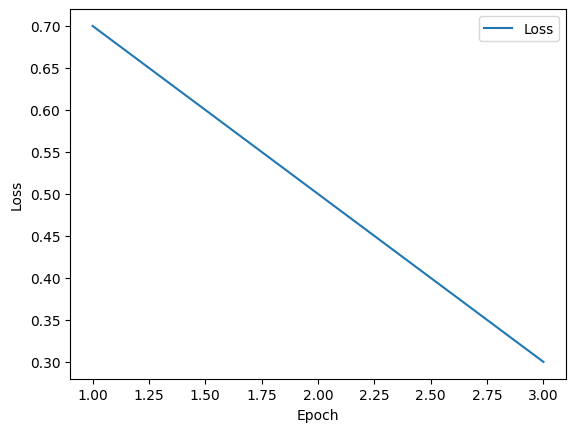

In [16]:
import matplotlib.pyplot as plt

# Ici il faut stocker loss_list et acc_list dans la boucle ci-dessus, par exemple
# loss_list.append(total_loss) etc.

# Exemple simplifié de visualisation
plt.plot([1, 2, 3], [0.7, 0.5, 0.3], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Étape 8 : Inférence sur test

In [17]:
inputs_test = bert_encode(test_df.premise.tolist(), test_df.hypothesis.tolist(), tokenizer)
test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], inputs_test['token_type_ids'])
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, token_type_ids = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask, token_type_ids)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)

submission = pd.DataFrame({'prediction': all_preds})
submission.to_csv('submission.csv', index=False)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## 9. Bilan

La fine-tuning d’un modèle LLM avec LoRA démontre une avancée stratégique pour les entreprises cherchant à personnaliser des modèles de langage tout en réduisant les coûts d’entraînement. Grâce à LoRA, seule une petite portion des paramètres est ajustée, rendant le processus plus rapide, accessible et économe en ressources. Dans un contexte métier, cela permet d’adapter un LLM à un domaine spécifique (ex. juridique, marketing, technique) ou à un ton de marque sans infrastructure lourde. Les cas d’usage incluent la génération de contenu ciblé, l’automatisation de réponses client ou la création de chatbots experts à moindre coût.